# TME 3 - Evaluation

In [34]:
import import_ipynb
import tme1Indexation as tm
import tme2
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from math import gamma, sqrt, pi
import seaborn as sns

#  Exercice 1 – Exercice de compréhension : calcul des mesures

On considère la collection de documents (cisi.txt et cacm.txt) et la liste des stopwords (TextRepresenter.py) du TME1 ainsi que les fonctions d’appariement codées dans l’exercice 1 du TME 2. L’objectif dans cet exercice est de mesurer la qualité de l’ordonnancement. Pour cela, on d´eﬁnit les jugements de pertinence suivant :

— Requête 1 ”top sales” - Documents pertinents : 1 

— Requête 2 ”sales increase july” - Documents pertinents : 2 et 3 (avec 2 plus pertinent que 3) 

— Requête 3 ”new home”

Q 1.1 Calculer les mesures de précision, rappel et F-mesure au rang 2 (P@2, R@2 et F@2) pour chaque requête et ensuite leur moyenne sur l’ensemble des requêtes.

#  Enjeux de l’évaluation en RI


Quel modèle de RI est le plus eﬃcace (dans le tme2 , on en a définit 3 (Vectoriel, Langue, Okapi bm25) )?
De nombreuses mesures donnent des renseignements partiels sur le comportement du système.
Objectif : évaluer la capacité d’un système à retourner des documents pertinents.
Pour faire cette évaluation , on a besoin d'un corpus de document (cisi.txt ou cacm.txt) , de requêtes (requête1 , requête2, requête3) et de jugements de pertinence pour chacune des requêtes (exemple: pour la requête1 , il a été jugé que seul le document1 était pertinent).

Comment mesurer l’eﬃcacité d’un système ?
Il y a diﬀérents types de mesure :

-Rappel/Précision

– Orientées rang 

– Prise en compte des degrés de pertinence

Evaluation d’un système:  On calcul ces mesures pour chaque requête , et on fait la moyenne sur chacune des requêtes.

# Evaluation des differents modèles

Je saute cette étape car les modèles que j'ai crée ,utilise un nom de fichier pour créer l'index , alors que la je ne dispose pas de fichier avec les infos dont j'ai besoin pour faire cette question.

# Exercice 2 – Projet ”Moteur de Recherche” : Etape Evaluation


# 1 Chargement du jeu de données

Q 2.1 Construire une classe Query qui permet de stocker l’identiﬁant de la requête, son texte et la liste des identiﬁants des documents pertinents.

In [2]:
class Query():
    
    def __init__(self,idquery,texte,docsPertinents):
        self.idquery=idquery
        self.texte=texte
        self.docsPertinents=docsPertinents
        
    def getId(self):
        return self.idquery
    
    def getText(self):
        return self.texte
    
    def getDocs(self):
        return self.docsPertinents

Q 2.2 Construire une classe QueryParser permettant de lire les ﬁchiers de tests de requêtes et de jugements de pertinence qui retourne une collection de Query.

La fonction Docs lit un fichier extension rel , et retourne un Dictionnaire dont la clé correspond à l'identifiant de la requête , et la valeur associé est une liste d'id de documents pertinent pour cette requête

In [3]:
def Docs(fic):
    D={}
    file = open(fic, "r")
    lines = file.readlines()
    file.close()
    L=[]
    for line in lines:
        l=line.strip().split()
        if(l[0] not in D):
            D[l[0]]=[l[1]]
        else:
            D[l[0]].append(l[1])
    return D

La classe QueryParser lit les ﬁchiers de tests de requêtes et de jugements de pertinence d'une collection de documents , et retourne collection d'objet Query.
Elle prend en paramètre le nom d'une collection

In [4]:
class QueryParser():
    
    def __init__(self,col): #prend le nom d'une collection en paramètre
        self.col=col
        
    
    def CollectQuery(self):
        V=[]
        A=[]
        D=tm.buildDocCollectionSimple(self.col+"/"+self.col+".qry")
       
        L=Docs(self.col+"/"+self.col+".rel")
        for c,v in D.items():

            idreq=v['.I']
            texte=v['.W']
            
            if( idreq in L):  
                docspertinent=L[idreq]
                
            elif ( str(0)+idreq in L):         #dans le cas où dans le fichier rel ,  l'id de la requete est de la forme "01" par exemple
                docspertinent=L[str(0)+idreq]
            else:
                docspertinent=[]

            Q=Query(idreq,texte,docspertinent)
            V.append(Q)
            A.append((idreq,texte,docspertinent))  # j'utilise A pour voir à quoi ressemble le résultat retourné
        return V,A

In [5]:
C=QueryParser("cacm")
T,A=C.CollectQuery()

# 2) Métrique

On souhaite maintenant implémenter les mesures d’évaluation (à minima, P@k, R@k, AP, NDCG pour chaque requête).

Q 2.3 Créer une classe abstraite EvalMesure qui contient une méthode abstraite evalQuery(liste,query) permettant de calculer la mesure pour la liste des documents retournés par un modèle et un objet Query.

Les moteurs de recherche renvoient en général des listes ordonnées : l’idéal est de retourner les documents en tête de liste.

In [6]:
class EvalMesure():
    
    #def __init__(self): 
                
    def evalQuery(liste,query):
        raise NotImplementedError
    

Test:

In [136]:
C=QueryParser("cacm")
T,A=C.CollectQuery()
query=T[0] #je prend le premier objet Query (la première requête)
req=query.getText()

In [140]:
w=tme2.Weighter4("cacm/cacm.txt") #je construit un weighter (chaque weigther à sa façon de représenter les vecteurs poids des documents et de la requête)
V=tme2.Vectoriel(w,False) # J'utilise le modèle Vectoriel pour retourner les documents en rapport avec la requête
Scores=V.getRanking(req) # Je récupere les documents en rapport avec la requête, dans leur ordre d'importance

La fontion get ranking retourne une liste de tuple (id_document,score). Pour évaluer les mesures , je n'ai besoin que de l'id des documents. La fonction toListId() va faire cela.

In [6]:
def toListId(D):
    L=[]
    for t in D:
        L.append(t[0])
    return L

In [216]:
docs=toListId(Scores) # L'ordre d'importance des documents est préservé

2.4 Créer les classes associées à chaque mesure d’évaluation (précision/rappel/f-measure au rang k, précision moyenne, reciprocal rank, ndcg - au minimum); ces classes héritent de la classe abstraite EvalMesure.

# Precision

Précision : est-ce que le système retourne QUE les documents pertinents ?

Précision = capacité à ne retrouver QUE des documents pertinents = documents pertinent récupérés / ( documents pertinents récupérés + documents non pertinents récupérés)

Précision à k : P@k(q)= 1/k * somme(de i=1 à k) Rdi,q avec Rdi,q ∈{0,1} jugement de pertinence pour le document de rang i renvoyé par le système. 

In [7]:
class Precision(EvalMesure):
    
    def __init__(self,k):
        self.k=k          #rang auquel on souhaite évaluer la précision du modèle choisit
                
    def evalQuery(self,liste,query):
        L=liste[:self.k]
        p=0
        j=query.getDocs()
        
        if(len(j)==0):  # il se peut que pour cette requête aucun document ne soit jugé pertinent.
            return 0
        
        for l in L:
            if (l in j ):
                p=p+1
        if(len(L)==0):
            return 0
        else:
            return p/len(L)
            
    

Remarque: Il faut que le rang k soit au moins aussi grand que le nombre de documents jugés pertinent pour la requête.

In [154]:
l=len(query.getDocs())
P=Precision(l)
p=P.evalQuery(docs,query)

In [156]:
print("Pour la première requête du fichier cacm.qry de la collection cacm , le modèle Vectoriel retourne",
      " les ",l," premiers  documents pertinents à cette requête avec une précision égale à : ", p)

Pour la première requête du fichier cacm.qry de la collection cacm , le modèle Vectoriel retourne  les  5  premiers  documents pertinents à cette requête avec une précision égale à :  0.0


Observation: Au vu de la faible précision obtenue (égale à 0) sur l'évaluation de cette requête , il est nécessaire de récupérer plus de documents parmis ceux retournés par la méthode getRanking() du modèle choisit.

La meilleur précison  pour l'évaluation de la première requête du fichier cacm.qry est égale à :  0.0011899095668729176  . Elle est obtenue quand on récupère  85  documents de ceux retourné par la méthode getRanking() du modèle choisit (ici c'est le modèle Vectoriel)


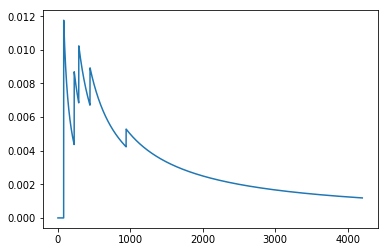

In [160]:
lmin,lmax=len(query.getDocs()),len(Scores)

precisions=[] #liste des précisions obtenue en fonctions du nombre k de documents qu'on récupère parmis ceux retournés par le modèle
L=[] #nombre de docs recupéres à chaque itération
maxx=0
i=-1
for k in range(lmin,lmax):
    P=Precision(k)
    p=P.evalQuery(docs,query)
    if(p>maxx):
        maxx=p
        i=k
    precisions.append(p)
    L.append(k)
    
plt.plot(L,precisions)
print("La meilleur précison  pour l'évaluation de la première requête du fichier cacm.qry est égale à : "
      ,p," . Elle est obtenue quand on récupère ",i," documents de ceux retourné par la méthode getRanking()",
      "du modèle choisit (ici c'est le modèle Vectoriel)")

La fonction RangOptimal prend en paramètre un minimum , un maximum , une liste de documents , un objet query. Elle retourne le rang i à partir duquel il faut garder les documents retournés par la méthode getRanking du modèle. Ce rang i permettra au modèle d'avoir une meilleure précision sur la requête qu'il évalue.

In [163]:
def RangOptimal(a,b,d,q):
    maxx=0
    i=-1
    for k in range(a,b):
        Pr=Precision(k)
        p=Pr.evalQuery(d,q)
        if(p>maxx):
            maxx=p
            i=k
    return i

On peut aussi voir pour chaque requête du fichier cacm.qry , quelle est le nombre de documents retourné par le modèle , qu'il faut récupérer sur chaque requête pour maximiser la précision.

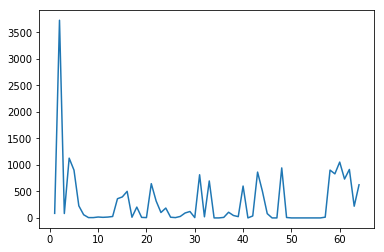

In [164]:
# T a été calculé au dessus , il contient une collection d'objet query , récupérer à partir de la colleciton cacm
Nb_Documents=[]  #Pour chaque requête du fichier cacm.qry  , on récupère le nombre de documents qu'on va garder parmis
#ceux retourné par la méthode getRanking() du modèle.  Ce nombre de documents sera celui qui maximisera la precison sur la requete qu'on évalue.
requetes=[] # les requetes qu'on évalue


for q in T:
    req=q.getText() # On récupère le texte de l'objet requête
    Scores=V.getRanking(req) #On utilise le modèle Vectoriel (V définit précedemment)
    docs=toListId(Scores) # On garde que les id des document retournés par le modèle, sans changer l'odre d'importance
    lmin,lmax=len(query.getDocs()),len(docs)
    k=RangOptimal(lmin,lmax,docs,q)  #on regarde quel est le rang optimal pour avoir une meilleur précison sur cette requête
    Nb_Documents.append(k)
    requetes.append(int(q.getId()))
    
plt.plot(requetes,Nb_Documents)

On remarque que pour avoir une précison maximale sur chacune de nos requêtes, le nombre de documents que l'on doit récupérer parmis ceux retournés par notre Modele ( ici Vectoriel) , varie selon les requêtes

On verra avec la précision moyenne comment régler ce problème

On verra par la suite comment récupérer le meilleur modèle qui nous donne la meilleur précision sur l'ensemble des requêtes

# Rappel

Rappel : est-ce que le système retourne TOUS les documents pertinents ? 

Rappel = capacité à retrouver TOUS les documents pertinents  = documents pertinent récupérés / ( documents pertinents récupérés + documents pertinents  non récupérés

Rappel à k : R@k(q)= 1/|R| * somme(de i=1 à k) Rdi,q avec Rdi,q ∈{0,1} jugement de pertinence pour le document de rang i renvoyé par le système. 

In [8]:
class Rappel(EvalMesure):
    
    def __init__(self,k):
        self.k=k          # rang auquel on souhaite évaluer la précision du modèle choisit, Pour améliorer la mesure de rappel
                          # sur une requête il est préférable de garder tous les documents retourné par le modèle , 
                        #car contrairement à la précision, cette mesure s'intéresse au fait que "TOUS" 
                        #les documents jugé pertinent ont été retourné et non "QUE" ceux qui ont été jugé
                        #pertinent parmis ceux retourné 
                
    def evalQuery(self,liste,query):
        L=liste[:self.k]
        p=0
        j=query.getDocs()
        for l in L:
            if (l in j ):
                p=p+1
        
        if(len(j)!=0) :       
            return p/len(j)
        else:
            return 0  # il se peut que pour une reqête , aucun documents de la collection ne soit jugé pertinents
            
    

# Courbe rappel/precision

In [427]:
col=QueryParser("cacm")
A,B=col.CollectQuery()

In [428]:
query=A[0] #je prend le premier objet Query (la première requête)
req=query.getText()

In [429]:
w=tme2.Weighter1("cacm/cacm.txt") 
V=tme2.Vectoriel(w,False) 
Scores=V.getRanking(req) 

La fonction Remove0 supprimer les documents retournés par le modèle dont le score est 0. 

In [9]:
def Remove0(D):
    L=[]
    for t in D:
        if(t[1] != 0):
            L.append(t[0])
    return L

In [434]:
S=Remove0(Scores)

In [440]:
precisions=[]
rappels=[]

for k in range (1,len(S)):
    Pr=Precision(k)
    p=Pr.evalQuery(S,query)
    Ra=Rappel(len(S))
    r=Ra.evalQuery(S,query)
    precisions.append(p)
    rappels.append(r)

On observe la valeur du rappel par rapport à la valeur de la précision. Pour faire ces mesure , on a évalué la premiere requête de la collection cacm , avec le modele Vectoriel ( qui utilisait weighter1pour calculer les poids de chaque documents)

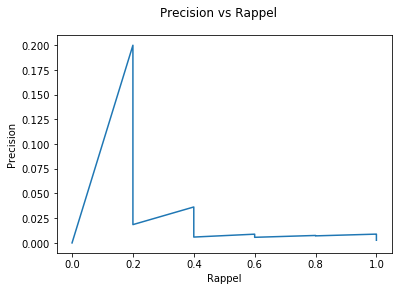

In [443]:
plt.plot(rappels,precisions)
plt.suptitle('Precision vs Rappel')
plt.xlabel('Rappel')
plt.ylabel('Precision')
plt.show()

(Le pic du début est du au fait que parmis les premiers documents retournés par le modèle on en a retrouvé quelque uns de pertinents).

Observation:

Il est facile de faire du rappel car il suffit de sélectionner toute la collection. Mais si on fait ça ,la précision sera très faible. Une précision très élevée a pour conséquence un  rappel très faible. De même , obtenir un rappel élevé a pour conséquence d'avoir  une précision faible. L'objectif serait d'avoir pour une précision élevée un rappel élevé (idéal, mais difficile).

# Précision moyenne 

On souhaite souvent avoir une valeur unique. La précision moyenne (AvgP) est la moyenne des valeurs de précision des documents pertinents par rapport à la requête.

Exemple:

Je récupère la première requête du fichier "cacm.qry" de la colleciton cacm. Je construit un modèle Vectoriel. J'utilise le modèle Vectoriel pour calculer le score de chaque document de la collection "cacm" pour cette requête. 
Je parcours la liste des documents retournés par le modèle , et à chaque apparition d'un document pertinent , je calcule la précison. Je fais la moyenne de toute les précisions obtenue (somme des précisions calculé à chaque apparition d'un document pertinent / nombre de documents pertinents).

AvgP(q)= 1/nq+ * somme(de k=1 à N(nombre total de documents retourné par le modèle)) Rdk,q x P@k(q)  avec Rdk,q ∈{0,1} jugement de pertinence pour le document de rang k renvoyé par le modèle. 

In [444]:
col=QueryParser("cacm")
A,B=col.CollectQuery()
query=A[0] #je prend le premier objet Query (la première requête)
req=query.getText()
w=tme2.Weighter1("cacm/cacm.txt") 
V=tme2.Vectoriel(w,False) 
Scores=V.getRanking(req) 

In [449]:
S=Remove0(Scores)

In [10]:
class AvgP(EvalMesure):
    
    #def __init__(self):
                 
                
    def evalQuery(self,liste,query):
        j=query.getDocs()  # liste des documents pertinent pour la reqête
        s=0 # je vais sommer les précisions calculés
        k=1 #pour enregister le rang
        
        if(len(j)==0):
            return 0    #il se peut que une requête , aucun documents ne soit jugé pertinents
        
        for d in liste:
            if (d in j):            # je tombe sur un document pertinent , alors je calcule la precision
                Pr=Precision(k)
                p=Pr.evalQuery(liste,query)
                s=s+p
            k=k+1
            
        return s/len(j)
        

In [467]:
Pm=AvgP()
moy=Pm.evalQuery(S,query)

In [468]:
print("la précision moyenne évalué pour la premiere requête de la collection cacm est égale à ",moy)

la précision moyenne évalué pour la premiere requête de la collection cacm est égale à  0.052331432170021196


# Moyenne des Moyennes

La moyenne des précisions moyennes (MAP) est la moyenne des AvgP sur l’ensemble des requêtes : 

MAP= 1/|Q|* somme (de q=1 à q=|Q|)AvgP(q)   où Q est le nombre de requête


In [11]:
class MAP():
    
    #def __init__(self):
                 
                
    def evalQuery(self,model,Ensquery):  # elle prend un ensemble d'objet query , et pas un seul
        s=0
        Pm=AvgP()
        
        for q in Ensquery:
            scores=model.getRanking(q.getText())
            liste=Remove0(scores)
            s=s+Pm.evalQuery(liste,q) # pour l'ensemble des requetes de la collection , on calule leur moyenne de précision
            
        return s/len(Ensquery)  # On retourne la moyenne des précisions moyennes sur l'ensemble des requêtes

In [470]:
M=MAP()
#m=M.evalQuery(V,A)

In [477]:
print("la moyenne des précisions moyennes sur l'ensemble des requêtes de la collection cacm , évalué ",
      "à partir du modèle vectoriel , est égale à :",m)

la moyenne des précisions moyennes sur l'ensemble des requêtes de la collection cacm , évalué  à partir du modèle vectoriel , est égale à : 0.0035208927253466676


# Autres mesures de moyennes 

# F-Mesure 

Mesure tenant compte à la fois du rappel et de la précision. Elle est  introduite par van Rijbergen en 1979.
Elle tient compte du poids accordé à la précision vis-à-vis du rappel

In [12]:
class FMesure(EvalMesure):
    
    def __init__(self,B,k):  # je calcule la F-mesure pour un certain rang k
        self.B=B
        self.k=k
                
    def evalQuery(self,liste,query):
        j=query.getDocs()  # liste des documents pertinent pour la reqête
                
        if(len(j)==0):
            return 0    #il se peut que une requête , aucun documents ne soit jugé pertinents
        
        Pr=Precision(self.k)
        p=Pr.evalQuery(liste,query)
        Ra=Rappel(self.k)
        r=Ra.evalQuery(liste,query)
        
        if( ( (self.B*self.B)*p+r ) ==0):
            return 0
        
        return ((1+self.B*self.B) *p*r )/((self.B*self.B)*p+r)

In [484]:
k=int(len(S)/2)
F=FMesure(1,k)
m=F.evalQuery(S,query)

In [485]:
print("La fmesure pour la premiere requete , évalué à partir des ",k," premiers document retournés par le ",
     " modèle est égale à ",m)

La fmesure pour la premiere requete , évalué à partir des  928  premiers document retournés par le   modèle est égale à  0.010718113612004289


– β = 1: même poids précision et recall 

- β > 1: préviligie la précision au rappel

– β < 1: plus d’importance au rappel. 

# Normalized Discounted Cumulatige Gain  (NDCG)

# DCG

Le principe du DCG est que les documents très pertinents apparaissant plus bas dans une liste de résultats de recherche doivent être pénalisés car la valeur de pertinence classée est réduite logarithmiquement proportionnellement à la position du résultat.

La formule traditionnelle du DCG accumulé à un rang particulier k pest défini comme:

DCGp =rel1 + somme (i=2 à k)  reli / log2(i)

# NDCG

Les listes de résultats de recherche varient en longueur selon la requête . La comparaison des performances d'un moteur de recherche d'une requête à la suivante ne peut pas être réalisée de manière cohérente en utilisant DCG seul, de sorte que le gain cumulé à chaque position pour une valeur choisie de k doit être normalisé entre les requêtes. Cela se fait en triant tous les documents pertinents dans le corpus par leur pertinence relative, produisant le DCG maximum possible par position k, également appelé Ideal DCG (IDCG) dans cette position. Pour une requête, le gain cumulé actualisé normalisé , ou nDCG, est calculé comme suit:

nDCGk = DCGk / IDCGk

In [13]:
class NDCG(EvalMesure):
    
    def __init__(self,k):  # je calcule le NDCG pour un certain rang k
        self.k=k
        
    def DCG(self,liste,query):
        j=query.getDocs()     #je récupère les documents jugés pertinents pourla requête
        liste=liste[:self.k]  # je garde les k premiers documents retourné par le modèle
        L=[]                # je stocke la pertinence de chaque documents retourné par le modèles
        
        for d in liste:
            if(d in j):
                L.append(1)  #si le document retourné par le modèle fait partit des documents pertinent, alors sa pertinence vaut 1
            else:
                L.append(0) # sinon la pertinence du document vaut 0
            
        if(len(L)==0):
            return 0
                
        somme=L[0]   
        for i in range (1,len(L)):
            somme=somme + (L[i]/np.log2(i+1))  #on applique la formule du DCG
        
        return somme
    
    
    def IDCG(self,liste,query):
        j=query.getDocs()     
        liste=liste[:self.k]  
        L=[]              
        
        for d in liste:
            if(d in j):
                L.append(1)  #si le document retourné par le modèle fait partit des documents pertinent, alors sa pertinence vaut 1
            else:
                L.append(0) # sinon la pertinence du document vaut 0
                
        if(len(L)==0):
            return 0 
        
        L=sorted(L,reverse=True)  # On trie tous les documents  dans le corpus par leur pertinence relative
        somme=L[0]   
        for i in range (1,len(L)):
            somme=somme + (L[i]/np.log2(i+1))  #on applique la formule du DCG
        
        return somme
                           
    
                
    def evalQuery(self,liste,query):
        
        d=self.IDCG(liste,query)
        if(d==0):
            return 0
        
        ndcg=self.DCG(liste,query)/d
        
        return ndcg
        

In [22]:
col=QueryParser("cacm")
A,B=col.CollectQuery()
query=A[0] #je prend le premier objet Query (la première requête)
req=query.getText()
w=tme2.Weighter1("cacm/cacm.txt") 
V=tme2.Vectoriel(w,False) 
Scores=V.getRanking(req) 

In [23]:
S=Remove0(Scores)

In [25]:
N=NDCG(len(S))
ndcg=N.evalQuery(S,query)

In [26]:
print("Le Gain cumulatif actualisé normalisé (NDCG) est égale à : ",ndcg," , pour la première requete de la ",
     "collection cacm évalué à partir du modèle Vectoriel et au rang : ",len(S))

Le Gain cumulatif actualisé normalisé (NDCG) est égale à :  0.26465476528663257  , pour la première requete de la  collection cacm évalué à partir du modèle Vectoriel et au rang :  1857


# 3 Plateforme d’´evaluation


Q 2.5 
Déﬁnir une classe EvalIRModel permettant l’évaluation de diﬀ´erents modèles de recherche sur un ensemble de requêtes selon diﬀérentes mesures d’évaluation. Les résultats devront être résumés pour l’ensemble des requêtes considérées en présentant la moyenne et l’écart-type pour chaque modèle.


On dispose de trois modèle:

- Le modèle Vectoriel .

- Le modèle de Langue.

- Le modèle Okapi BM-25


Pour chacun de ces modèles , On va considérer les deux collections : cisi et cacm. Chacune de ces deux collections conctient un fichier .qry contenant un ensemble de reqêtes. Pour le modèle considéré et la collection de documents considérée, on va calculer le score de chacun des documents de la collections. A partir de ces scores , on va appliqué les mesures définit ci dessus. 

Protocole: 

- Choisir un modèle de RI.
- Choisir une collection de documents.
- Récuperer l'ensemmble des requêtes.
- Choisir une mesure à appliquer.
- Appliquer la mesure sur chacune des requêtes à évaluer
- faire la moyenne des resultats obtenues sur chacune des requête.
- Ainsi on obtient le résultat de la mesure considérer pour l'ensemble des requêtes évalué par notre modèle.
- Calculer aussi l'écart type sur l'ensemble des résultats de la mesure.

# TEST MODELE VECTORIEL

Le modèle Vectoriel possède 5 possibilité différentes ( 5 weighter définit) de définir le vecteur poids des documents et de la requête considéré. Ainsi Il faudra définir le modèle Vectoriel sur chacun des weighter (afin d'observer les différents résultats obtenues en fonction du weighter utilisé pour définir le modèle vectoriel).


Ca veut dire que par exemple Vectoriel(weighter1,false) et Vectoriel(weighter2,false) sont deux modèles différents.
Tout comme Vectoriel(w,True) et Vectoriel(w,False) , pour un weighter quelconque ,dans l'un on utilise le score cosinus et dans l'autre le produit scalire.

# Test Numéro 1

Mon but ici est d'identifier quel est le meilleur modèle vectoriel à considérer sur chacune des mesures.
Pour les 10 modèles différents, on test à chaque fois 5 mesures différentes

Dans la classe EvalIRModel , j'ai fait une fonction asscoié à chaque mesure

In [54]:
class EvalIRModel():
    
    #cette fonction retourne la moyenne et l'écart_type des mesures
    #de précisions calculés sur l'ensemble des requêtes de la collection "col" à partir du modèle "model"
    
    def evalPrecision(self,model,col):  
        resultats=[]
        for query in col:
            texte=query.getText()
            scores=model.getRanking(texte)
            s=Remove0(scores)
            Pr=Precision(len(s)) # j'evalue la precision au rang len(s) 
            p=Pr.evalQuery(s,query)
            resultats.append(p)
        
        return np.mean(resultats),math.sqrt(np.var(resultats))
    
    
    #cette fonction retourne la moyenne et l'écart_type des mesures de rappel calculés
    #sur l'ensemble des requêtes de la collection "col" à partir du modèle "model"
     
    def evalRappel(self,model,col):  
        resultats=[]
        for query in col:
            texte=query.getText()
            scores=model.getRanking(texte)
            s=Remove0(scores)
            Ra=Rappel(len(s)) # j'evalue la precision au rang len(s) 
            r=Ra.evalQuery(s,query)
            resultats.append(r)
        
        return np.mean(resultats),math.sqrt(np.var(resultats))
    
    
    #cette fonction retourne la moyenne et l'écart_type des mesures de précisions moyennes calculés sur 
    #l'ensemble des requêtes de la collection "col" à partir du modèle "model"
    
    def evalAvgP(self,model,col):  
        resultats=[]
        for query in col:
            texte=query.getText()
            scores=model.getRanking(texte)
            s=Remove0(scores)
            P=AvgP() 
            m=P.evalQuery(s,query)
            resultats.append(m)
        
        return np.mean(resultats),math.sqrt(np.var(resultats))
    
    
     #cette fonction retourne la moyenne et l'écart_type des mesures des moyennes de précisions
     #moyennes calculés sur l'ensemble des requêtes de la collection "col" à partir du modèle "model"
     
    def evalMAP(self,model,col): 
        resultats=[]
    
        M=MAP()  
        m=M.evalQuery(model,col)
        resultats.append(m)
        
        return np.mean(resultats),math.sqrt(np.var(resultats))
    
    
     #cette fonction retourne la moyenne et l'écart_type des mesures des Fmesures calculés sur 
     #l'ensemble des requêtes de la collection "col" à partir du modèle "model"
        
    def evalFMesure(self,model,col,B):  
        resultats=[]
        for query in col:
            texte=query.getText()
            scores=model.getRanking(texte)
            s=Remove0(scores)
            F=FMesure(B,len(s))     # on évalue la Fmesure au rang len(s) ; pour un B>1 on privilégie 
                                    #la précison au rappel et inversement
            f=F.evalQuery(s,query)
            resultats.append(f)
        
        return np.mean(resultats),math.sqrt(np.var(resultats))
    
    #cette fonction retourne la moyenne et l'écart_type des mesures NDCG 
    #calculés sur l'ensemble des requêtes de la collection "col" à partir du modèle "model"
    
    def evalNDCG(self,model,col):  
        resultats=[]
        for query in col:
            texte=query.getText()
            scores=model.getRanking(texte)
            s=Remove0(scores)
            N=NDCG(len(s)) # j'evalue la precision au rang len(s) 
            n=N.evalQuery(s,query)
            resultats.append(n)
        
        return np.mean(resultats),math.sqrt(np.var(resultats))
    
    
    def student(self,x, df):
    #densité de probabilité de la loi de student
        r = gamma((df+1)/2)/(sqrt(pi*df)*gamma(df/2))*(1+x*x/df)**(-(df+1)/2)
        return r
     
    def qstudent(self,df, alpha):
        #valeur du quantile en fonction de alpha bilatéral et df=deg. de lib.
        x = 0
        dx = 6/10000
        s = 0
        while 1-2*s>alpha:
            x += dx
            s += dx*student(x-dx/2, df)
        return x    


    def t_test(self,X,Y,A):  #paramètre:  2 échantillions de donnnées issue des mesures de 2 modèles  , et une collection 

        mx,my=np.mean(X),np.mean(Y)
        Vxy= ( sum( pow(X[i]-mx,2) for i in range(0,len(X)) ) + sum( pow(Y[i]-my,2) for i in range(0,len(Y)) ) )/(len(X)+len(Y)-2)
        tcalc=(mx-my)/math.sqrt(Vxy/len(A))
        df = len(X)+len(Y)-2
        alpha=0.05
        t=round(self.qstudent(df,alpha),3)

        if(abs(tcalc) > t):
            print("H0 est rejeté à ",alpha*100," %")
        else:
            print("H0 est accepté à ",alpha*100," %")    
    
    

In [52]:
E=EvalIRModel()

In [16]:
w1=tme2.Weighter1("cacm/cacm.txt")
V1=tme2.Vectoriel(w1,False)

In [22]:
col=QueryParser("cacm")
A,B=col.CollectQuery()   # les objets query sont contenus dans A

In [24]:
# pour chaque mesure utilisé ,  on récupère la  moyenne et l'ecart-type de l'ensemble des résultats obtenue
# pour cette mesure sur la collection cacm , en ayant utilisé le modèle V1

nm,ne=E.evalNDCG(V1,A)
pm,pe=E.evalPrecision(V1,A)
rm,re=E.evalRappel(V1,A)
mm,me=E.evalAvgP(V1,A)
mam,mae=E.evalMAP(V1,A)
fm,fe=E.evalFMesure(V1,A,1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [25]:
print("Pour le Modèle Vectoriel  utilisant weighter1 et le produit scalaire (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pm," /  ecart-type de la précison = ",pe,"\n",
     "moyenne du rappel =",rm," /  ecart-type du rappel = ",re,"\n",
     "moyenne Avgp =",mm," /  ecart-type AvgP = ",me,"\n",
     "moyenne MAP =",mam," /  ecart-type MAP = ",mae,"\n",
     "moyenne FMesure =",fm," /  ecart-type FMesure = ",fe,"\n",
     "moyenne NDCG =",nm," /  ecart-type NDCG = ",ne,"\n")

Pour le Modèle Vectoriel  utilisant weighter1 et le produit scalaire (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.005677354625449063  /  ecart-type de la précison =  0.0056687163934020495 
 moyenne du rappel = 0.6095061519317104  /  ecart-type du rappel =  0.3557461634407892 
 moyenne Avgp = 0.050298134791742125  /  ecart-type AvgP =  0.13381015795737286 
 moyenne MAP = 0.050298134791742125  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.011180934814213183  /  ecart-type FMesure =  0.011062870464342874 
 moyenne NDCG = nan  /  ecart-type NDCG =  nan 



In [26]:
V2=tme2.Vectoriel(w1,True) #on utilise le score cosinus et plus le produit scalaire

In [27]:
# pour chaque mesure utilisé ,  on récupère la  moyenne et l'ecart-type de l'ensemble des résultats obtenue
# pour cette mesure sur la collection cacm , en ayant utilisé le modèle V2

pm2,pe2=E.evalPrecision(V2,A)
rm2,re2=E.evalRappel(V2,A)
mm2,me2=E.evalAvgP(V2,A)
mam2,mae2=E.evalMAP(V2,A)
fm2,fe2=E.evalFMesure(V2,A,1)
nm2,ne2=E.evalNDCG(V2,A)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [28]:
print("Pour le Modèle Vectoriel  utilisant weighter1 et le score Cosinus (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pm2," /  ecart-type de la précison = ",pe2,"\n",
     "moyenne du rappel =",rm2," /  ecart-type du rappel = ",re2,"\n",
     "moyenne Avgp =",mm2," /  ecart-type AvgP = ",me2,"\n",
     "moyenne MAP =",mam2," /  ecart-type MAP = ",mae2,"\n",
     "moyenne FMesure =",fm2," /  ecart-type FMesure = ",fe2,"\n",
     "moyenne NDCG =",nm2," /  ecart-type NDCG = ",ne2,"\n",)

Pour le Modèle Vectoriel  utilisant weighter1 et le score Cosinus (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.005677354625449063  /  ecart-type de la précison =  0.0056687163934020495 
 moyenne du rappel = 0.6095061519317104  /  ecart-type du rappel =  0.3557461634407892 
 moyenne Avgp = 0.12500621111292176  /  ecart-type AvgP =  0.19077592796429546 
 moyenne MAP = 0.12500621111292173  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.011180934814213183  /  ecart-type FMesure =  0.011062870464342874 
 moyenne NDCG = nan  /  ecart-type NDCG =  nan 



In [29]:
w2=tme2.Weighter2("cacm/cacm.txt")
V3=tme2.Vectoriel(w2,False)

In [30]:
# pour chaque mesure utilisé ,  on récupère la  moyenne et l'ecart-type de l'ensemble des résultats obtenue
# pour cette mesure sur la collection cacm , en ayant utilisé le modèle V3

pm3,pe3=E.evalPrecision(V3,A)
rm3,re3=E.evalRappel(V3,A)
mm3,me3=E.evalAvgP(V3,A)
mam3,mae3=E.evalMAP(V3,A)
fm3,fe3=E.evalFMesure(V3,A,1)
nm3,ne3=E.evalNDCG(V3,A)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [31]:
print("Pour le Modèle Vectoriel  utilisant weighter2 et le produit scalaire (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pm3," /  ecart-type de la précison = ",pe3,"\n",
     "moyenne du rappel =",rm3," /  ecart-type du rappel = ",re3,"\n",
     "moyenne Avgp =",mm3," /  ecart-type AvgP = ",me3,"\n",
     "moyenne MAP =",mam3," /  ecart-type MAP = ",mae3,"\n",
     "moyenne FMesure =",fm3," /  ecart-type FMesure = ",fe3,"\n",
     "moyenne NDCG =",nm3," /  ecart-type NDCG = ",ne3,"\n",)

Pour le Modèle Vectoriel  utilisant weighter2 et le produit scalaire (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.005677354625449063  /  ecart-type de la précison =  0.0056687163934020495 
 moyenne du rappel = 0.6095061519317104  /  ecart-type du rappel =  0.3557461634407892 
 moyenne Avgp = 0.05409363361005343  /  ecart-type AvgP =  0.13412290159233264 
 moyenne MAP = 0.05409363361005343  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.011180934814213183  /  ecart-type FMesure =  0.011062870464342874 
 moyenne NDCG = nan  /  ecart-type NDCG =  nan 



In [32]:
V4=tme2.Vectoriel(w2,True)

In [33]:
# pour chaque mesure utilisé ,  on récupère la  moyenne et l'ecart-type de l'ensemble des résultats obtenue
# pour cette mesure sur la collection cacm , en ayant utilisé le modèle V4

pm4,pe4=E.evalPrecision(V4,A)
rm4,re4=E.evalRappel(V4,A)
mm4,me4=E.evalAvgP(V4,A)
mam4,mae4=E.evalMAP(V4,A)
fm4,fe4=E.evalFMesure(V4,A,1)
nm4,ne4=E.evalNDCG(V4,A)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [34]:
print("Pour le Modèle Vectoriel  utilisant weighter2 et le score cosinus (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pm4," /  ecart-type de la précison = ",pe4,"\n",
     "moyenne du rappel =",rm4," /  ecart-type du rappel = ",re4,"\n",
     "moyenne Avgp =",mm4," /  ecart-type AvgP = ",me4,"\n",
     "moyenne MAP =",mam4," /  ecart-type MAP = ",mae4,"\n",
     "moyenne FMesure =",fm4," /  ecart-type FMesure = ",fe4,"\n",
     "moyenne NDCG =",nm4," /  ecart-type NDCG = ",ne4,"\n",)

Pour le Modèle Vectoriel  utilisant weighter2 et le score cosinus (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.005677354625449063  /  ecart-type de la précison =  0.0056687163934020495 
 moyenne du rappel = 0.6095061519317104  /  ecart-type du rappel =  0.3557461634407892 
 moyenne Avgp = 0.11560732349087754  /  ecart-type AvgP =  0.16938590783536459 
 moyenne MAP = 0.11560732349087754  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.011180934814213183  /  ecart-type FMesure =  0.011062870464342874 
 moyenne NDCG = nan  /  ecart-type NDCG =  nan 



In [35]:
w3=tme2.Weighter3("cacm/cacm.txt")
V5=tme2.Vectoriel(w3,False)

In [36]:
# pour chaque mesure utilisé ,  on récupère la  moyenne et l'ecart-type de l'ensemble des résultats obtenue
# pour cette mesure sur la collection cacm , en ayant utilisé le modèle V5

pm5,pe5=E.evalPrecision(V5,A)
rm5,re5=E.evalRappel(V5,A)
mm5,me5=E.evalAvgP(V5,A)
mam5,mae5=E.evalMAP(V5,A)
fm5,fe5=E.evalFMesure(V5,A,1)
nm5,ne5=E.evalNDCG(V5,A)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [37]:
print("Pour le Modèle Vectoriel  utilisant weighter3 et le produit vectoriel (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pm5," /  ecart-type de la précison = ",pe5,"\n",
     "moyenne du rappel =",rm5," /  ecart-type du rappel = ",re5,"\n",
     "moyenne Avgp =",mm5," /  ecart-type AvgP = ",me5,"\n",
     "moyenne MAP =",mam5," /  ecart-type MAP = ",mae5,"\n",
     "moyenne FMesure =",fm5," /  ecart-type FMesure = ",fe5,"\n",
     "moyenne NDCG =",nm5," /  ecart-type NDCG = ",ne5,"\n",)

Pour le Modèle Vectoriel  utilisant weighter3 et le produit vectoriel (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.005677354625449063  /  ecart-type de la précison =  0.0056687163934020495 
 moyenne du rappel = 0.6095061519317104  /  ecart-type du rappel =  0.3557461634407892 
 moyenne Avgp = 0.04766162303283028  /  ecart-type AvgP =  0.13103826689499332 
 moyenne MAP = 0.047661623032830294  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.011180934814213183  /  ecart-type FMesure =  0.011062870464342874 
 moyenne NDCG = nan  /  ecart-type NDCG =  nan 



In [38]:
V6=tme2.Vectoriel(w3,True)

In [39]:
# pour chaque mesure utilisé ,  on récupère la  moyenne et l'ecart-type de l'ensemble des résultats obtenue
# pour cette mesure sur la collection cacm , en ayant utilisé le modèle V6

pm6,pe6=E.evalPrecision(V6,A)
rm6,re6=E.evalRappel(V6,A)
mm6,me6=E.evalAvgP(V6,A)
mam6,mae6=E.evalMAP(V6,A)
fm6,fe6=E.evalFMesure(V6,A,1)
nm6,ne6=E.evalNDCG(V6,A)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [40]:
print("Pour le Modèle Vectoriel  utilisant weighter3 et le score cosinus (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pm6," /  ecart-type de la précison = ",pe6,"\n",
     "moyenne du rappel =",rm6," /  ecart-type du rappel = ",re6,"\n",
     "moyenne Avgp =",mm6," /  ecart-type AvgP = ",me6,"\n",
     "moyenne MAP =",mam6," /  ecart-type MAP = ",mae6,"\n",
     "moyenne FMesure =",fm6," /  ecart-type FMesure = ",fe6,"\n",
     "moyenne NDCG =",nm6," /  ecart-type NDCG = ",ne6,"\n",)

Pour le Modèle Vectoriel  utilisant weighter3 et le score cosinus (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.005677354625449063  /  ecart-type de la précison =  0.0056687163934020495 
 moyenne du rappel = 0.6095061519317104  /  ecart-type du rappel =  0.3557461634407892 
 moyenne Avgp = 0.14120971093443013  /  ecart-type AvgP =  0.19612723736066384 
 moyenne MAP = 0.14120971093443013  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.011180934814213183  /  ecart-type FMesure =  0.011062870464342874 
 moyenne NDCG = nan  /  ecart-type NDCG =  nan 



In [17]:
w4=tme2.Weighter4("cacm/cacm.txt")
V7=tme2.Vectoriel(w4,False)

In [42]:
# pour chaque mesure utilisé ,  on récupère la  moyenne et l'ecart-type de l'ensemble des résultats obtenue
# pour cette mesure sur la collection cacm , en ayant utilisé le modèle V7

pm7,pe7=E.evalPrecision(V7,A)
rm7,re7=E.evalRappel(V7,A)
mm7,me7=E.evalAvgP(V7,A)
mam7,mae7=E.evalMAP(V7,A)
fm7,fe7=E.evalFMesure(V7,A,1)
nm7,ne7=E.evalNDCG(V7,A)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [43]:
print("Pour le Modèle Vectoriel  utilisant weighter4 et le produit vectoriel (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pm7," /  ecart-type de la précison = ",pe7,"\n",
     "moyenne du rappel =",rm7," /  ecart-type du rappel = ",re7,"\n",
     "moyenne Avgp =",mm7," /  ecart-type AvgP = ",me7,"\n",
     "moyenne MAP =",mam7," /  ecart-type MAP = ",mae7,"\n",
     "moyenne FMesure =",fm7," /  ecart-type FMesure = ",fe7,"\n",
     "moyenne NDCG =",nm7," /  ecart-type NDCG = ",ne7,"\n",)

Pour le Modèle Vectoriel  utilisant weighter4 et le produit vectoriel (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.005677354625449063  /  ecart-type de la précison =  0.0056687163934020495 
 moyenne du rappel = 0.6095061519317104  /  ecart-type du rappel =  0.3557461634407892 
 moyenne Avgp = 0.032426043183932864  /  ecart-type AvgP =  0.06448837302184007 
 moyenne MAP = 0.032426043183932864  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.011180934814213183  /  ecart-type FMesure =  0.011062870464342874 
 moyenne NDCG = nan  /  ecart-type NDCG =  nan 



In [18]:
V8=tme2.Vectoriel(w4,True)

In [45]:
# pour chaque mesure utilisé ,  on récupère la  moyenne et l'ecart-type de l'ensemble des résultats obtenue
# pour cette mesure sur la collection cacm , en ayant utilisé le modèle V8

pm8,pe8=E.evalPrecision(V8,A)
rm8,re8=E.evalRappel(V8,A)
mm8,me8=E.evalAvgP(V8,A)
mam8,mae8=E.evalMAP(V8,A)
fm8,fe8=E.evalFMesure(V8,A,1)
nm8,ne8=E.evalNDCG(V8,A)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [46]:
print("Pour le Modèle Vectoriel  utilisant weighter4 et le score cosinus (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pm8," /  ecart-type de la précison = ",pe8,"\n",
     "moyenne du rappel =",rm8," /  ecart-type du rappel = ",re8,"\n",
     "moyenne Avgp =",mm8," /  ecart-type AvgP = ",me8,"\n",
     "moyenne MAP =",mam8," /  ecart-type MAP = ",mae8,"\n",
     "moyenne FMesure =",fm8," /  ecart-type FMesure = ",fe8,"\n",
     "moyenne NDCG =",nm8," /  ecart-type NDCG = ",ne8,"\n",)

Pour le Modèle Vectoriel  utilisant weighter4 et le score cosinus (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.005677354625449063  /  ecart-type de la précison =  0.0056687163934020495 
 moyenne du rappel = 0.6095061519317104  /  ecart-type du rappel =  0.3557461634407892 
 moyenne Avgp = 0.15373553758793645  /  ecart-type AvgP =  0.1810796876866562 
 moyenne MAP = 0.15373553758793645  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.011180934814213183  /  ecart-type FMesure =  0.011062870464342874 
 moyenne NDCG = nan  /  ecart-type NDCG =  nan 



In [47]:
w5=tme2.Weighter5("cacm/cacm.txt")
V9=tme2.Vectoriel(w5,False)

In [48]:
# pour chaque mesure utilisé ,  on récupère la  moyenne et l'ecart-type de l'ensemble des résultats obtenue
# pour cette mesure sur la collection cacm , en ayant utilisé le modèle V9

pm9,pe9=E.evalPrecision(V9,A)
rm9,re9=E.evalRappel(V9,A)
mm9,me9=E.evalAvgP(V9,A)
mam9,mae9=E.evalMAP(V9,A)
fm9,fe9=E.evalFMesure(V9,A,1)
nm9,ne9=E.evalNDCG(V9,A)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [49]:
print("Pour le Modèle Vectoriel  utilisant weighter5 et le produit vectoriel (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pm9," /  ecart-type de la précison = ",pe9,"\n",
     "moyenne du rappel =",rm9," /  ecart-type du rappel = ",re9,"\n",
     "moyenne Avgp =",mm9," /  ecart-type AvgP = ",me9,"\n",
     "moyenne MAP =",mam9," /  ecart-type MAP = ",mae9,"\n",
     "moyenne FMesure =",fm9," /  ecart-type FMesure = ",fe9,"\n",
     "moyenne NDCG =",nm9," /  ecart-type NDCG = ",ne9,"\n",)

Pour le Modèle Vectoriel  utilisant weighter5 et le produit vectoriel (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.005677354625449063  /  ecart-type de la précison =  0.0056687163934020495 
 moyenne du rappel = 0.6095061519317104  /  ecart-type du rappel =  0.3557461634407892 
 moyenne Avgp = 0.04627795168695898  /  ecart-type AvgP =  0.10514279907545568 
 moyenne MAP = 0.04627795168695898  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.011180934814213183  /  ecart-type FMesure =  0.011062870464342874 
 moyenne NDCG = nan  /  ecart-type NDCG =  nan 



In [50]:
V10=tme2.Vectoriel(w5,True)

In [51]:
# pour chaque mesure utilisé ,  on récupère la  moyenne et l'ecart-type de l'ensemble des résultats obtenue
# pour cette mesure sur la collection cacm , en ayant utilisé le modèle V10

pm10,pe10=E.evalPrecision(V10,A)
rm10,re10=E.evalRappel(V10,A)
mm10,me10=E.evalAvgP(V10,A)
mam10,mae10=E.evalMAP(V10,A)
fm10,fe10=E.evalFMesure(V10,A,1)
nm10,ne10=E.evalNDCG(V10,A)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [52]:
print("Pour le Modèle Vectoriel  utilisant weighter5 et le score cosinus (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pm10," /  ecart-type de la précison = ",pe10,"\n",
     "moyenne du rappel =",rm10," /  ecart-type du rappel = ",re10,"\n",
     "moyenne Avgp =",mm10," /  ecart-type AvgP = ",me10,"\n",
     "moyenne MAP =",mam10," /  ecart-type MAP = ",mae10,"\n",
     "moyenne FMesure =",fm10," /  ecart-type FMesure = ",fe10,"\n",
     "moyenne NDCG =",nm10," /  ecart-type NDCG = ",ne10,"\n",)

Pour le Modèle Vectoriel  utilisant weighter5 et le score cosinus (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.005677354625449063  /  ecart-type de la précison =  0.0056687163934020495 
 moyenne du rappel = 0.6095061519317104  /  ecart-type du rappel =  0.3557461634407892 
 moyenne Avgp = 0.14674603878344433  /  ecart-type AvgP =  0.19673278247124534 
 moyenne MAP = 0.14674603878344433  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.011180934814213183  /  ecart-type FMesure =  0.011062870464342874 
 moyenne NDCG = nan  /  ecart-type NDCG =  nan 



# Observation : Le meilleur Modele Vectoriel

Pour chaque mesure, on détermine le meilleur modèle vectoriel:

Ils ont tous la même moyenne de précision et de rappel et moyenneFmesure.
V8 a la meilleur moyenne Avgp et MAP.


REMARQUE :
Pour le modèle de langue et okapi BM20 le weighter utilisé n'a pas d'importance

In [24]:
M=tme2.ModeleLangue(w1,0.2)  # 0.2 pour les requêtes longues , faudrait pour chaque requete créer un nouveau modèle en fonction 
# de la taille de la requête pour que le modèle soit plus efficace

pmM,peM=E.evalPrecision(M,A)
rmM,reM=E.evalRappel(M,A)
mmM,meM=E.evalAvgP(M,A)
mamM,maeM=E.evalMAP(M,A)
fmM,feM=E.evalFMesure(M,A,1)
nmM,neM=E.evalNDCG(M,A)

In [26]:
print("Pour le Modèle de Langue  (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pmM," /  ecart-type de la précison = ",peM,"\n",
     "moyenne du rappel =",rmM," /  ecart-type du rappel = ",reM,"\n",
     "moyenne Avgp =",mmM," /  ecart-type AvgP = ",meM,"\n",
     "moyenne MAP =",mamM," /  ecart-type MAP = ",maeM,"\n",
     "moyenne FMesure =",fmM," /  ecart-type FMesure = ",feM,"\n",
     "moyenne NDCG =",nmM," /  ecart-type NDCG = ",neM,"\n",)

Pour le Modèle de Langue  (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.002237984772781347  /  ecart-type de la précison =  0.0026309036083278095 
 moyenne du rappel = 0.5645349645244275  /  ecart-type du rappel =  0.47203663080419095 
 moyenne Avgp = 0.0996342765463527  /  ecart-type AvgP =  0.1265280869164075 
 moyenne MAP = 0.0996342765463527  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.0044502276503530355  /  ecart-type FMesure =  0.005217890066502017 
 moyenne NDCG = 0.29459129842409626  /  ecart-type NDCG =  0.2724403620004733 



In [19]:
O=tme2.Okapi(w1,1.2,0.75) 

In [19]:
O=tme2.Okapi(w1,1.2,0.75) 

pmO,peO=E.evalPrecision(O,A)
rmO,reO=E.evalRappel(O,A)
mmO,meO=E.evalAvgP(O,A)
mamO,maeO=E.evalMAP(O,A)
fmO,feO=E.evalFMesure(O,A,1)
nmO,neO=E.evalNDCG(O,A)

In [21]:
print("Pour le Modèle OKAPI  (calculé à partir de la colleciton cacm)",
      " on obtient: \n\n",
     "moyenne de la précision =",pmO," /  ecart-type de la précison = ",peO,"\n",
     "moyenne du rappel =",rmO," /  ecart-type du rappel = ",reO,"\n",
     "moyenne Avgp =",mmO," /  ecart-type AvgP = ",meO,"\n",
     "moyenne MAP =",mamO," /  ecart-type MAP = ",maeO,"\n",
     "moyenne FMesure =",fmO," /  ecart-type FMesure = ",feO,"\n",
     "moyenne NDCG =",nmO," /  ecart-type NDCG = ",neO,"\n",)

Pour le Modèle OKAPI  (calculé à partir de la colleciton cacm)  on obtient: 

 moyenne de la précision = 0.011429677490711665  /  ecart-type de la précison =  0.03704659219306671 
 moyenne du rappel = 0.13994522337782261  /  ecart-type du rappel =  0.20496973289488218 
 moyenne Avgp = 0.011381507661071225  /  ecart-type AvgP =  0.030737024149828616 
 moyenne MAP = 0.011381507661071225  /  ecart-type MAP =  0.0 
 moyenne FMesure = 0.01623270907468194  /  ecart-type FMesure =  0.04515349616194069 
 moyenne NDCG = 0.14118124810707222  /  ecart-type NDCG =  0.19971529980892275 



# 4 Bonus - 2.6 et 2.7 très fortement conseill´es


Q 2.6 Compléter la classe EvalIRModel pour permettre de calculer des tests de signiﬁcativité entre deux modèles (t-test) pour tester si deux modèles sont signiﬁcativement diﬀérents.

# Comparaison des systèmes de RI

# T-test

Le test-t de Student est un test statistique permettant de comparer les moyennes de deux groupes d’échantillons. Il s’agit donc de savoir si les moyennes des deux groupes sont significativement différentes au point de vue statistique.

Dans notre cas de figure, il s’agit de comparer deux moyennes observées. Lorsque les deux groupes d’échantillons (X et Y) à comparer n’ont aucun lien, on utilise le test t de Student indépendant (ou non apparié).

On a deux modèle A et B, pour chacun de ces deux modèles , on calcule la mesure  sur les 64 requêtes de la collection cacm.
On se pose la question à savoir si la mesure moyenne du modèle A  est significativement différente de celle du modèle B ?
Dans cet exemple on parle de test de Student non apparié car les deux groupes à comparer n’ont aucun lien. Il s’agit donc de calculer la mesure moyenne du modèle A et de celle du modèle B et d’évaluer si la différence est significative au point de vue statistique.

Le modèle A est le modèle Vectoriel appelé V8 ici , et le modèle B est le modèle Okapi appellé O ici.

Formule:

- Soit X et Y deux groupes différents à comparer.
- Soit mX et mY la moyenne du groupe X et celui du groupe Y, respectivement.
- Soit n la taille du groupe X et celle du groupe Y.

La valeur t de Student est donnée par la formule suivante: 

 - t=(mx-my)/racine(S au carré/n)
 
S au carré  est la variance commune aux deux groupes. Elle est calculée par la formule suivante :

 - S au carré= ( (somme (x-mx)^2 ) + (somme (x-my)^2 ) ) / (n+n-2)

Exemple T -Test:

Hypothèse  Null : la moyenne de la distribution de ces différences est zéro

In [24]:
V8=tme2.Vectoriel(w4,True)
O=tme2.Okapi(w1,1.2,0.75) 

In [23]:
X=[]
for query in A:
    texte=query.getText()
    scores=V8.getRanking(texte)
    s=Remove0(scores)
    N=Precision(len(s))
    n=N.evalQuery(s,query)
    X.append(n)

In [24]:
Y=[]
for query in A:
    texte=query.getText()
    scores=O.getRanking(texte)
    s=Remove0(scores)
    N=Precision(len(s))
    n=N.evalQuery(s,query)
    Y.append(n)

In [25]:
mx,my=np.mean(X),np.mean(Y)
Vxy= ( sum( pow(X[i]-mx,2) for i in range(0,len(X)) ) + sum( pow(Y[i]-my,2) for i in range(0,len(Y)) ) ) / (len(X)+len(Y)-2)

In [26]:
tcalc=(mx-my)/math.sqrt(Vxy/len(A)) # len(A)=len(X)=len(Y)=64=nombre de requetes évalués

In [27]:
print("La valeur t de Student = ",tcalc)

La valeur t de Student =  -1.7228783586220955


Pour savoir si la différence est significative, il faut tout d’abord lire dans la table t, la valeur critique correspondant au risque alpha = 5% pour un degré de liberté : ddl=len(X)+len(Y)-2

Si la valeur absolue de t (|t|) est supérieure à la valeur critique, alors la différence est significative (on dit que H0 est rejeté au risque alpha de se tromper) . Dans le cas contraire, elle, ne l’est pas. Le degré de siginificativité ou p-value correspond au risque indiqué par la table de Student pour la valeur |t|

La fonction student(x, df) calcule la densité de probabilité de la loi de student avec df=nombre de degrés de liberté. Elle est assez facile à calculer grâce à la fonction gamma qui fait partie du module math.

La fonction qstudent(df, alpha) calcule la valeur de x pour que la surface (=la probabilité) entre -x et +x soit égale à 1-alpha. Avec df=nombre de degrés de liberté.

In [32]:
def student(x, df):
    """densité de probabilité de la loi de student"""   
    r = gamma((df+1)/2)/(sqrt(pi*df)*gamma(df/2))*(1+x*x/df)**(-(df+1)/2)
    return r
     
def qstudent(df, alpha):
    """valeur du quantile en fonction de alpha bilatéral et df=deg. de lib."""
    x = 0
    dx = 6/10000
    s = 0
    while 1-2*s>alpha:
        x += dx
        s += dx*student(x-dx/2, df)
    return x    
 
df = len(X)+len(Y)-2
t=round(qstudent(df,0.05),3)
print("t:",t)

t: 1.979


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


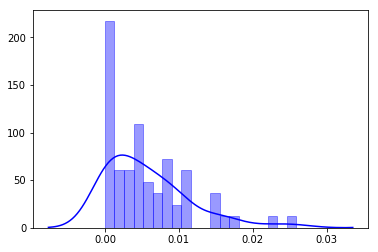

In [35]:
sns.distplot(X, hist=True, kde=True, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'blue'})

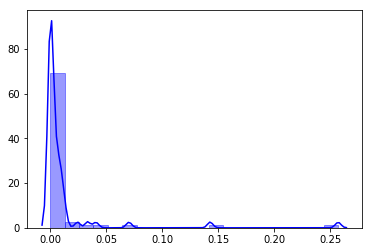

In [36]:
sns.distplot(Y, hist=True, kde=True, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'blue'})

Remarque:

ICI Le test n'est pas utilisable, car  X et Y ne suivent pas  des lois normales de même variances

On récapitule toute ces étapes dans une fonction t_test 

Avant d'appliquer ce test , il faut vérifier que les deux échantillions X et Y ont la même variance , et suivent tous les deux une loi normale.

In [53]:
E.t_test(X,Y,A)

H0 est accepté à  5.0  %


# Explication

Test de “significativité” permet de :
 -  Rejeter l’hypothèse nulle (pas de différence entre modeleA et modeleB)  :H0
 -  Accepter l’hypothèse alternative (modelA et modelB sont différents)     :H1
 
H0 est rejetée à α  si tcalc >  t(α:υ)   (Degré de liberté (v=N-1)  N=taille de l’échantillon)  à lire dans la table de la loi de student )

Dire qu’une différence est significative à :  x  si p-value < x/100
 - Valeurs de x considérées 
 - 0.05 (ou 5%) signifie : il y a 95% de chances que la différence ne soit pas due au hasard 

En statistiques, le résultat d'études qui portent sur des échantillons de population est dit statistiquement significatif lorsqu'il semble exprimer de façon fiable un fait auquel on s'intéresse, par exemple la différence entre 2 groupes ou une corrélation entre 2 données. Dit autrement, il est alors très peu probable que ce résultat apparent soit en fait trompeur s'il n'est pas dû, par exemple, à un échantillon erroné (en), trop petit ou autrement non représentatif (surtout si la population est très diverse). Cette fiabilité se traduit généralement par des valeurs, différences de valeurs, ou rapports entre valeurs, suffisamment élévées ou au contraire faibles.

Techniquement, on évalue cette fiabilité selon une méthode qui suit le raisonnement suivant : On part de l'hypothèse qu'un résultat soit vraie, ce qu'on nomme l'hypothèse nulle. Et on s'accorde une probabilité, c'est-à-dire ici un risque acceptable, de rejeter cette hypothèse nulle alors qu'elle serait en fait vraie. Ce risque d'erreur noté alpha est souvent fixé à 5%, mais parfois à des valeurs bien plus faibles selon les domaines. Enfin, on calcule ce risque-là sur cette étude en particulier (dit valeur p ou p valeur, de l'anglais p-value), et on dira que l'étude est statistiquement significative si p < α.

Test bilatéral:

Un test bilatéral est associé à une  d’hypothèse alternative selon laquelle le signe de la différence potentielle est inconnu. Par exemple, nous cherchons à comparer les moyennes de deux échantillons X et Y. Avant de mettre en place l’expérimentation et de lancer le test, nous ne savons pas avec certitude si X serait supérieur à Y ou le contraire dans la situation où une différence entre X et Y serait mise en relief par le test. Ceci nous conduit à opter pour un test bilatéral, associé à l’hypothèse alternative suivante : moyenne(X) ≠ moyenne(Y). 

Dans le cas du test t de Student pour la comparaison de deux échantillons, la statistique calculée est la statistique t. Une statistique t calculée se situant à droite du centre de la distribution reflète une différence positive entre les deux moyennes. A l’inverse, une statistique t se trouvant à gauche du centre de la distribution est le résultat d’une différence négative entre les deux moyennes.
Avant la collecte des données, nous ignorons souvent le signe de la différence potentielle entre les deux moyennes. En d’autres termes, nous ne savons pas si la statistique t se trouvera sur le côté gauche ou le côté droit de la courbe sous l’hypothèse alternative. Ici, une hypothèse alternative bilatérale est appropriée.

# Q 2.7 Poursuivre l’optimisation des paramètres du TME 2 en considérant comme critère à optimiser la valeur de MAP.

On sépare l’ensemble des requêtes en deux ensembles (train/test) et on déﬁnit une recherche de valeur optimale par GridSearch. 1) déﬁnir une grille de valeurs à tester (e.g., de 0 à 1 par pas de 0.1). 2) expérimenter chaque combinaison possible pour chaque modèle sur le jeu de donn´ees train. 3) on pourra tester la combinaison qui obtient la meilleure valeur de métrique (MAP, Pr´ecision, ...), 4) on applique ces valeurs sur le jeu de test

In [60]:
train=A[:int(len(A)/2)-1]
test=A[int(len(A)/2):]

In [66]:
G={}
M=MAP()  
resultats={}
for k in np.arange(0,1.1,0.1):
    for b in np.arange(0,1.1,0.1):
        Mo=tme2.Okapi(w1,k,b)
        d={}
        m=M.evalQuery(Mo,train)
        resultats[(k,b)]=m

In [68]:
maxi = None
param=None
for k in resultats:
    if maxi is None or resultats[k] > maxi:
        maxi = resultats[k]
        param=k
        
print("les meilleurs paramètres à utiliser sont pour le modèle okapi sont :",param)

les meilleurs paramètres à utiliser sont pour le modèle okapi sont : (0.1, 0.9)


In [69]:
O=tme2.Okapi(w1,0.1,0.9)
m=M.evalQuery(O,test)
print("Map=",m)

Map= 0.007336582664107241
